# Import Libraries

In [1]:
import numpy as np
import torch

from visualization import *
from main import *
from used_attacks import regression_PGD

''' Settings and seeds '''

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

print("device:", device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 
    
''' test dataset '''

x = np.linspace(0, 1, 256)

x_test = x.reshape(x.shape[0],1)
print("test dataset:", x_test.shape, '\n')

''' model '''

layers = np.array([1,20,20,20,20,20,20,20,20,1]) #8 hidden layers
PINN = sequential_model(layers, device)
PINN.to(device)
print(PINN)

def gt(x):
    epsilon = 5e-4
    return (np.exp(-x)- np.exp(-x/epsilon))/(np.exp(-1) - np.exp(-1/epsilon))
u_test = gt(x_test)

device: cpu
test dataset: (256, 1) 

sequential_model(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [2]:
def generate_attack_samples(model, device, x_train, N0, n_samples=200, \
    lb=[0], ub=[1], steps=2, eps=2e-1, eta=2e-2, m=0):
    
    attack = regression_PGD(model, lb=lb, ub=ub, steps=steps, eps=eps, eta=eta)
    x_adv = attack.attack(x_train).cpu().detach().numpy()
    
    if x_adv.shape[0] > N0 + (m+1)*n_samples:
        x_adv = np.vstack([x_adv[:N0,:] ,x_adv[-(m+1)*n_samples:,:]])

    f_adv_pred = np.abs(model.function(x_adv).squeeze().cpu().detach().numpy())
    index = np.argsort(f_adv_pred)[::-1][:n_samples]
    x_adv = x_adv[index,:]
    f_adv_pred = f_adv_pred[index]
    
    plot_samples(x_adv, f_adv_pred)
    
    return x_adv


def retrain(model, x_train, x_adv, x_boundary, u_boundary, x_test, epoch=2e4):
    
    x_train_temp = np.vstack([x_train, x_adv])
    
    f_test_pred = np.abs(model.function(x_test).squeeze().cpu().detach().numpy())
    plot_u(x_test, f_test_pred, title="test $r(x;theta)$", ylim=[-1,3])
    print('Test residual MSE: %.5f'  % (np.mean(np.square(f_test_pred))))

    model.iter = 0
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    model.train_model_adam(optimizer, x_boundary, u_boundary, x_train_temp, epoch)
    
    #u_pred = model(x_test).squeeze().cpu().detach().numpy()
    
    rmse, u_pred = model.test(x_test, u_test)
    print('Test RMSE: %.5f'  % (rmse))
    plt.figure()
    plt.plot(x_test, u_test, 'r')
    plt.plot(x_test, u_pred, 'b')

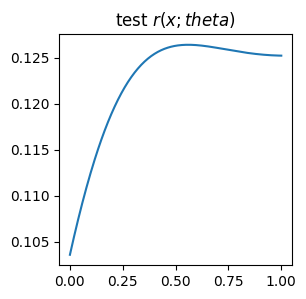

Test residual MSE: 0.01504
1000 tensor(2.4947, grad_fn=<AddBackward0>)
Test RMSE: 0.76613


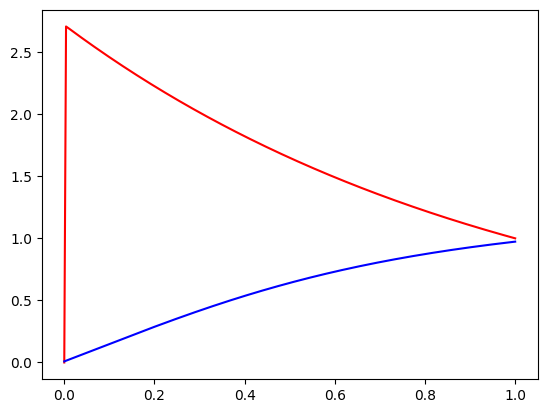

In [3]:
''' k=0 '''
N0 = 200
x_train, x_boundary, u_boundary = training_data_latin_hypercube(x, N_inner=N0)
retrain(PINN, x_train, np.array([]).reshape((0,1)), x_boundary, u_boundary, x_test, epoch=1e3)

k= 0


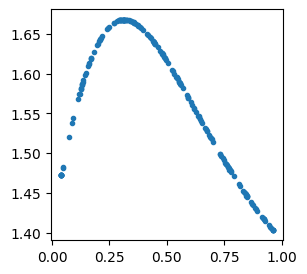

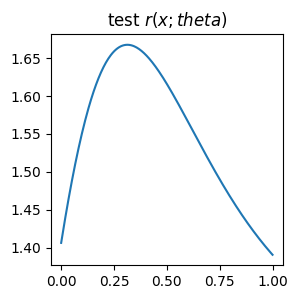

Test residual MSE: 2.41392
1000 tensor(2.2000, grad_fn=<AddBackward0>)
2000 tensor(2.1943, grad_fn=<AddBackward0>)
3000 tensor(2.1899, grad_fn=<AddBackward0>)
4000 tensor(2.1873, grad_fn=<AddBackward0>)
5000 tensor(2.1877, grad_fn=<AddBackward0>)
6000 tensor(2.1866, grad_fn=<AddBackward0>)
7000 tensor(2.1863, grad_fn=<AddBackward0>)
8000 tensor(2.1863, grad_fn=<AddBackward0>)
9000 tensor(2.1863, grad_fn=<AddBackward0>)
10000 tensor(2.1863, grad_fn=<AddBackward0>)
11000 tensor(2.1863, grad_fn=<AddBackward0>)
12000 tensor(2.1862, grad_fn=<AddBackward0>)
13000 tensor(2.1862, grad_fn=<AddBackward0>)
14000 tensor(2.1862, grad_fn=<AddBackward0>)
15000 tensor(2.1862, grad_fn=<AddBackward0>)
16000 tensor(2.1863, grad_fn=<AddBackward0>)
17000 tensor(2.1862, grad_fn=<AddBackward0>)
18000 tensor(2.1888, grad_fn=<AddBackward0>)
19000 tensor(2.1862, grad_fn=<AddBackward0>)
20000 tensor(2.1861, grad_fn=<AddBackward0>)
21000 tensor(2.1860, grad_fn=<AddBackward0>)
22000 tensor(2.1860, grad_fn=<AddBack

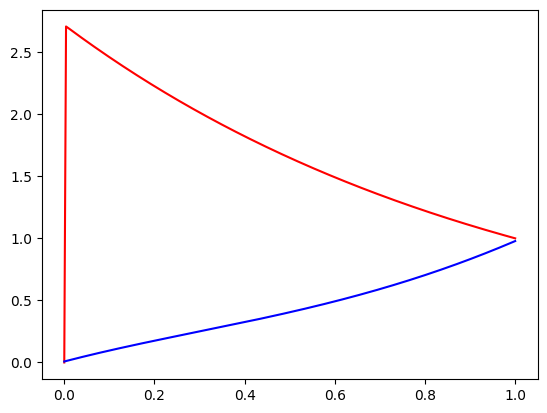

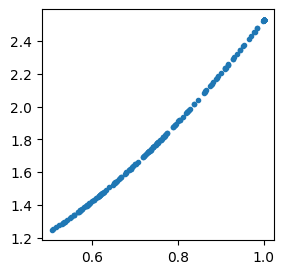

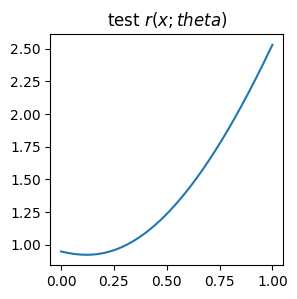

Test residual MSE: 2.22168
1000 tensor(2.4297, grad_fn=<AddBackward0>)
2000 tensor(2.4285, grad_fn=<AddBackward0>)
3000 tensor(2.4279, grad_fn=<AddBackward0>)
4000 tensor(2.4272, grad_fn=<AddBackward0>)
5000 tensor(2.4250, grad_fn=<AddBackward0>)
6000 tensor(2.4233, grad_fn=<AddBackward0>)
7000 tensor(2.4231, grad_fn=<AddBackward0>)
8000 tensor(2.4229, grad_fn=<AddBackward0>)
9000 tensor(2.4227, grad_fn=<AddBackward0>)
10000 tensor(2.4225, grad_fn=<AddBackward0>)
11000 tensor(2.4225, grad_fn=<AddBackward0>)
12000 tensor(2.4222, grad_fn=<AddBackward0>)
13000 tensor(2.4220, grad_fn=<AddBackward0>)
14000 tensor(2.4218, grad_fn=<AddBackward0>)
15000 tensor(2.4217, grad_fn=<AddBackward0>)
16000 tensor(2.4213, grad_fn=<AddBackward0>)
17000 tensor(2.4209, grad_fn=<AddBackward0>)
18000 tensor(2.4201, grad_fn=<AddBackward0>)
19000 tensor(2.4195, grad_fn=<AddBackward0>)
20000 tensor(2.4162, grad_fn=<AddBackward0>)
21000 tensor(2.4050, grad_fn=<AddBackward0>)
22000 tensor(2.3756, grad_fn=<AddBack

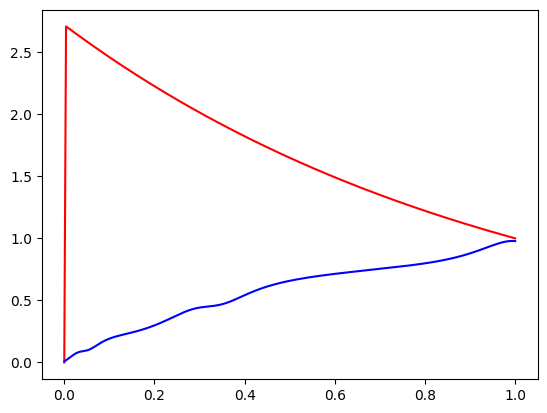

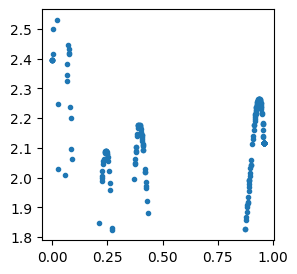

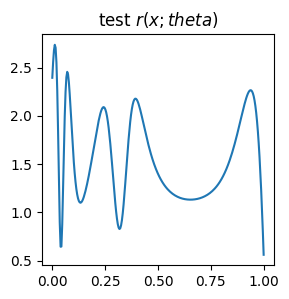

Test residual MSE: 2.58747
1000 tensor(2.2984, grad_fn=<AddBackward0>)
2000 tensor(2.2844, grad_fn=<AddBackward0>)
3000 tensor(2.2437, grad_fn=<AddBackward0>)
4000 tensor(2.0560, grad_fn=<AddBackward0>)
5000 tensor(2.0436, grad_fn=<AddBackward0>)
6000 tensor(2.0373, grad_fn=<AddBackward0>)
7000 tensor(2.0298, grad_fn=<AddBackward0>)
8000 tensor(2.0218, grad_fn=<AddBackward0>)
9000 tensor(2.0138, grad_fn=<AddBackward0>)
10000 tensor(2.0081, grad_fn=<AddBackward0>)
11000 tensor(2.0035, grad_fn=<AddBackward0>)
12000 tensor(1.9816, grad_fn=<AddBackward0>)
13000 tensor(1.9866, grad_fn=<AddBackward0>)
14000 tensor(1.9491, grad_fn=<AddBackward0>)
15000 tensor(1.9314, grad_fn=<AddBackward0>)
16000 tensor(1.9326, grad_fn=<AddBackward0>)
17000 tensor(1.9174, grad_fn=<AddBackward0>)
18000 tensor(1.9167, grad_fn=<AddBackward0>)
19000 tensor(1.9117, grad_fn=<AddBackward0>)
20000 tensor(1.9089, grad_fn=<AddBackward0>)
21000 tensor(1.9057, grad_fn=<AddBackward0>)
22000 tensor(1.9019, grad_fn=<AddBack

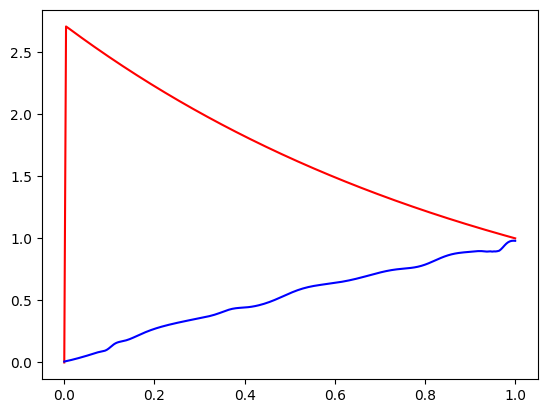

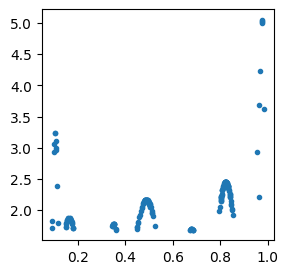

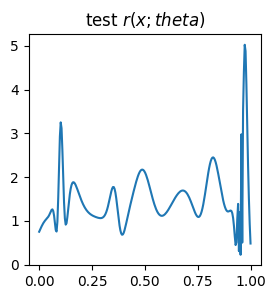

Test residual MSE: 2.65433
1000 tensor(2.1958, grad_fn=<AddBackward0>)
2000 tensor(2.1487, grad_fn=<AddBackward0>)
3000 tensor(2.0938, grad_fn=<AddBackward0>)
4000 tensor(2.0443, grad_fn=<AddBackward0>)
5000 tensor(2.0189, grad_fn=<AddBackward0>)
6000 tensor(1.9986, grad_fn=<AddBackward0>)
7000 tensor(1.9827, grad_fn=<AddBackward0>)
8000 tensor(1.9662, grad_fn=<AddBackward0>)
9000 tensor(1.9503, grad_fn=<AddBackward0>)
10000 tensor(1.9407, grad_fn=<AddBackward0>)
11000 tensor(1.9318, grad_fn=<AddBackward0>)
12000 tensor(1.9247, grad_fn=<AddBackward0>)
13000 tensor(1.9129, grad_fn=<AddBackward0>)
14000 tensor(1.9250, grad_fn=<AddBackward0>)
15000 tensor(1.9045, grad_fn=<AddBackward0>)
16000 tensor(1.8957, grad_fn=<AddBackward0>)
17000 tensor(1.9001, grad_fn=<AddBackward0>)
18000 tensor(1.8915, grad_fn=<AddBackward0>)
19000 tensor(1.8822, grad_fn=<AddBackward0>)
20000 tensor(1.8799, grad_fn=<AddBackward0>)
21000 tensor(1.8726, grad_fn=<AddBackward0>)
22000 tensor(1.8681, grad_fn=<AddBack

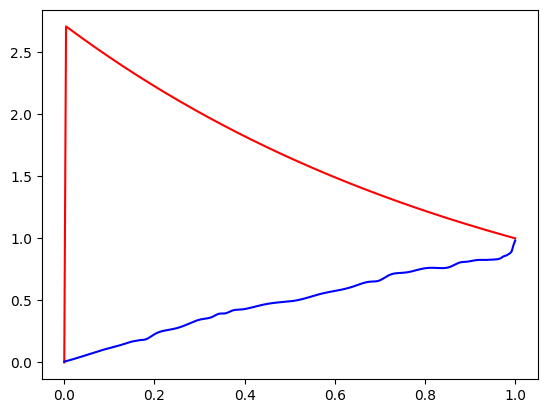

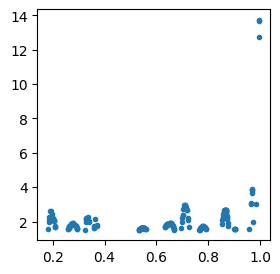

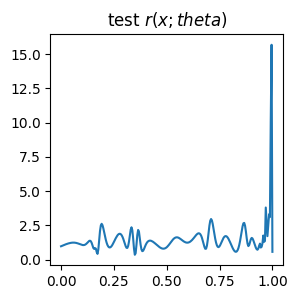

Test residual MSE: 3.49455
1000 tensor(2.1266, grad_fn=<AddBackward0>)
2000 tensor(2.1091, grad_fn=<AddBackward0>)
3000 tensor(2.1039, grad_fn=<AddBackward0>)
4000 tensor(2.0995, grad_fn=<AddBackward0>)
5000 tensor(2.0956, grad_fn=<AddBackward0>)
6000 tensor(2.0919, grad_fn=<AddBackward0>)
7000 tensor(2.0882, grad_fn=<AddBackward0>)
8000 tensor(2.0853, grad_fn=<AddBackward0>)
9000 tensor(2.0827, grad_fn=<AddBackward0>)
10000 tensor(2.0798, grad_fn=<AddBackward0>)
11000 tensor(2.0759, grad_fn=<AddBackward0>)
12000 tensor(2.0718, grad_fn=<AddBackward0>)
13000 tensor(2.0647, grad_fn=<AddBackward0>)
14000 tensor(2.0493, grad_fn=<AddBackward0>)
15000 tensor(2.0301, grad_fn=<AddBackward0>)
16000 tensor(1.9701, grad_fn=<AddBackward0>)
17000 tensor(1.8706, grad_fn=<AddBackward0>)
18000 tensor(1.6545, grad_fn=<AddBackward0>)
19000 tensor(1.1785, grad_fn=<AddBackward0>)
20000 tensor(2.3354, grad_fn=<AddBackward0>)
21000 tensor(2.3166, grad_fn=<AddBackward0>)
22000 tensor(2.2903, grad_fn=<AddBack

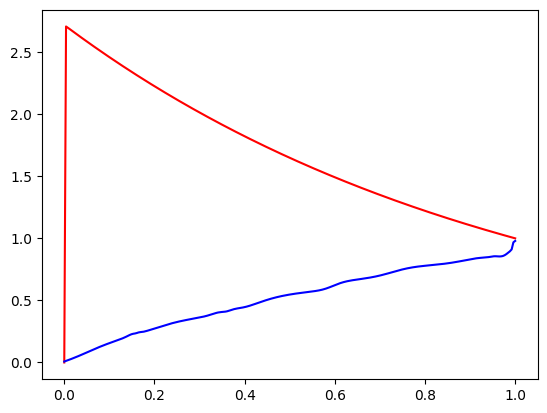

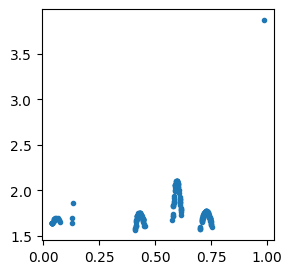

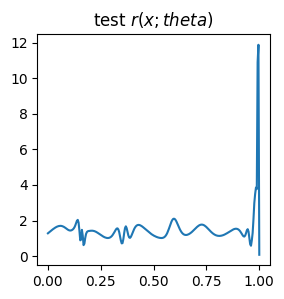

Test residual MSE: 3.14795
1000 tensor(2.0950, grad_fn=<AddBackward0>)
2000 tensor(2.0335, grad_fn=<AddBackward0>)
3000 tensor(1.8912, grad_fn=<AddBackward0>)
4000 tensor(2.4683, grad_fn=<AddBackward0>)
5000 tensor(2.0806, grad_fn=<AddBackward0>)
6000 tensor(2.0235, grad_fn=<AddBackward0>)
7000 tensor(1.9218, grad_fn=<AddBackward0>)
8000 tensor(1.6422, grad_fn=<AddBackward0>)
9000 tensor(2.4755, grad_fn=<AddBackward0>)
10000 tensor(2.4007, grad_fn=<AddBackward0>)
11000 tensor(2.3902, grad_fn=<AddBackward0>)
12000 tensor(2.3832, grad_fn=<AddBackward0>)
13000 tensor(2.3772, grad_fn=<AddBackward0>)
14000 tensor(2.3708, grad_fn=<AddBackward0>)
15000 tensor(2.3502, grad_fn=<AddBackward0>)
16000 tensor(2.3068, grad_fn=<AddBackward0>)
17000 tensor(2.1618, grad_fn=<AddBackward0>)
18000 tensor(2.1080, grad_fn=<AddBackward0>)
19000 tensor(2.0750, grad_fn=<AddBackward0>)
20000 tensor(2.0430, grad_fn=<AddBackward0>)
21000 tensor(1.9152, grad_fn=<AddBackward0>)
22000 tensor(26.0320, grad_fn=<AddBac

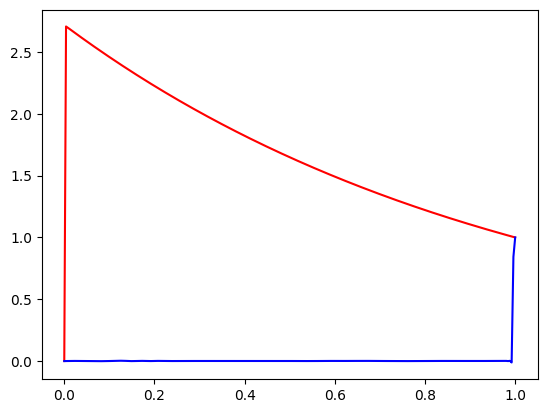

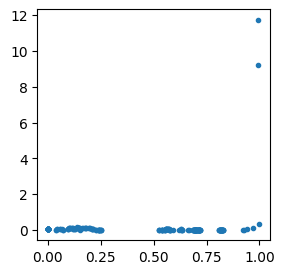

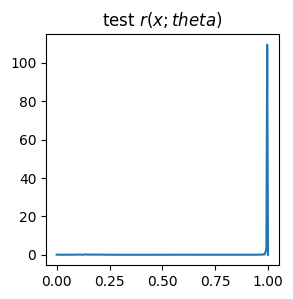

Test residual MSE: 46.85544
1000 tensor(0.0155, grad_fn=<AddBackward0>)
2000 tensor(0.0116, grad_fn=<AddBackward0>)
3000 tensor(0.0083, grad_fn=<AddBackward0>)
4000 tensor(0.0058, grad_fn=<AddBackward0>)
5000 tensor(0.0043, grad_fn=<AddBackward0>)
6000 tensor(0.0033, grad_fn=<AddBackward0>)
7000 tensor(0.0025, grad_fn=<AddBackward0>)
8000 tensor(0.0018, grad_fn=<AddBackward0>)
9000 tensor(0.0022, grad_fn=<AddBackward0>)
10000 tensor(0.0010, grad_fn=<AddBackward0>)
11000 tensor(0.0012, grad_fn=<AddBackward0>)
12000 tensor(0.0020, grad_fn=<AddBackward0>)
13000 tensor(3.5449, grad_fn=<AddBackward0>)
14000 tensor(2.9974, grad_fn=<AddBackward0>)
15000 tensor(2.7125, grad_fn=<AddBackward0>)
16000 tensor(2.5022, grad_fn=<AddBackward0>)
17000 tensor(2.3274, grad_fn=<AddBackward0>)
18000 tensor(1.7020, grad_fn=<AddBackward0>)
19000 tensor(2.4144, grad_fn=<AddBackward0>)
20000 tensor(2.2574, grad_fn=<AddBackward0>)
21000 tensor(2.1896, grad_fn=<AddBackward0>)
22000 tensor(2.1335, grad_fn=<AddBac

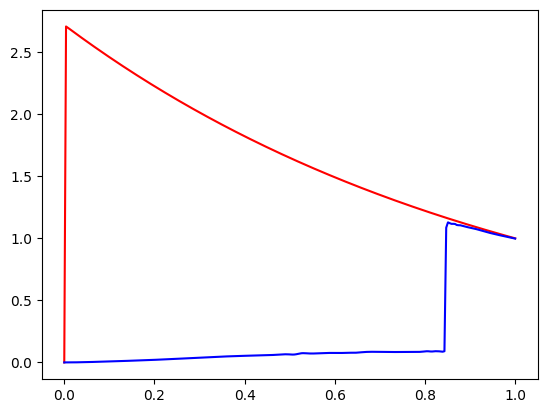

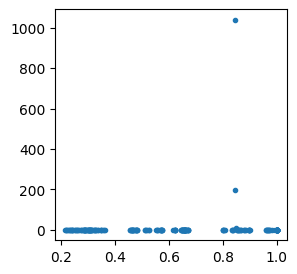

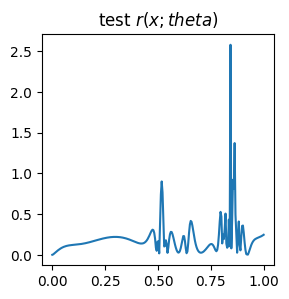

Test residual MSE: 0.08328
1000 tensor(1.0974, grad_fn=<AddBackward0>)
2000 tensor(1.2684, grad_fn=<AddBackward0>)
3000 tensor(1.1809, grad_fn=<AddBackward0>)
4000 tensor(1.1909, grad_fn=<AddBackward0>)
5000 tensor(0.5000, grad_fn=<AddBackward0>)
6000 tensor(0.1702, grad_fn=<AddBackward0>)
7000 tensor(0.0696, grad_fn=<AddBackward0>)
8000 tensor(2.2847, grad_fn=<AddBackward0>)
9000 tensor(1.5921, grad_fn=<AddBackward0>)
10000 tensor(1.4326, grad_fn=<AddBackward0>)
11000 tensor(1.2783, grad_fn=<AddBackward0>)
12000 tensor(1.0202, grad_fn=<AddBackward0>)
13000 tensor(2.4632, grad_fn=<AddBackward0>)
14000 tensor(2.1409, grad_fn=<AddBackward0>)
15000 tensor(1.9748, grad_fn=<AddBackward0>)
16000 tensor(1.8256, grad_fn=<AddBackward0>)
17000 tensor(1.6328, grad_fn=<AddBackward0>)
18000 tensor(1.1918, grad_fn=<AddBackward0>)
19000 tensor(7.5873, grad_fn=<AddBackward0>)
20000 tensor(2.3204, grad_fn=<AddBackward0>)
21000 tensor(2.2859, grad_fn=<AddBackward0>)
22000 tensor(2.2403, grad_fn=<AddBack

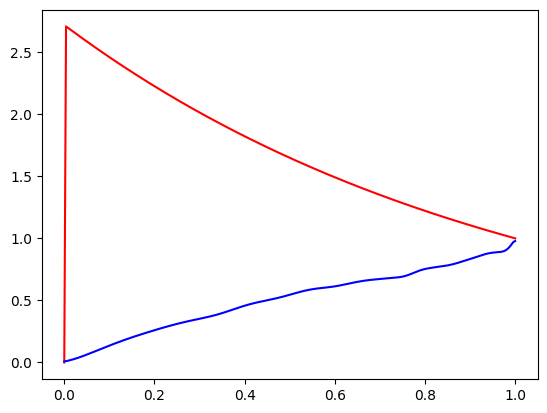

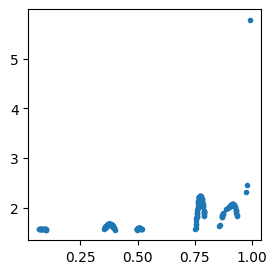

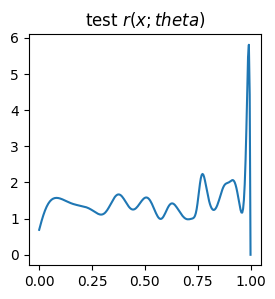

Test residual MSE: 2.48844
1000 tensor(2.2163, grad_fn=<AddBackward0>)
2000 tensor(2.2137, grad_fn=<AddBackward0>)
3000 tensor(2.2101, grad_fn=<AddBackward0>)
4000 tensor(2.2089, grad_fn=<AddBackward0>)
5000 tensor(2.1942, grad_fn=<AddBackward0>)
6000 tensor(2.1661, grad_fn=<AddBackward0>)
7000 tensor(2.1168, grad_fn=<AddBackward0>)
8000 tensor(2.1097, grad_fn=<AddBackward0>)
9000 tensor(2.1082, grad_fn=<AddBackward0>)
10000 tensor(2.1074, grad_fn=<AddBackward0>)
11000 tensor(2.1066, grad_fn=<AddBackward0>)
12000 tensor(2.1057, grad_fn=<AddBackward0>)
13000 tensor(2.1049, grad_fn=<AddBackward0>)
14000 tensor(2.1039, grad_fn=<AddBackward0>)
15000 tensor(2.1042, grad_fn=<AddBackward0>)
16000 tensor(2.1019, grad_fn=<AddBackward0>)
17000 tensor(2.0991, grad_fn=<AddBackward0>)
18000 tensor(2.0974, grad_fn=<AddBackward0>)
19000 tensor(2.0992, grad_fn=<AddBackward0>)
20000 tensor(2.0942, grad_fn=<AddBackward0>)
21000 tensor(2.0935, grad_fn=<AddBackward0>)
22000 tensor(2.0918, grad_fn=<AddBack

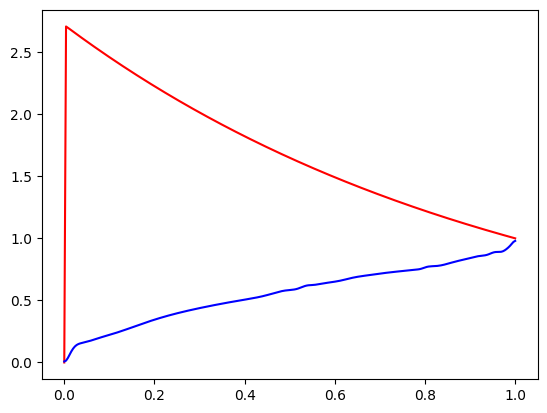

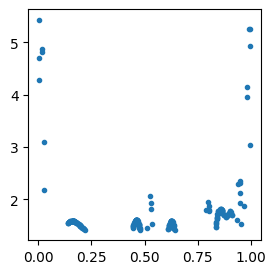

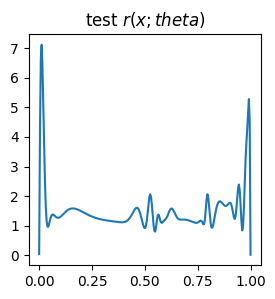

Test residual MSE: 3.02932
1000 tensor(2.1818, grad_fn=<AddBackward0>)
2000 tensor(2.1792, grad_fn=<AddBackward0>)
3000 tensor(2.1770, grad_fn=<AddBackward0>)
4000 tensor(2.1739, grad_fn=<AddBackward0>)
5000 tensor(2.1537, grad_fn=<AddBackward0>)
6000 tensor(2.1262, grad_fn=<AddBackward0>)
7000 tensor(2.1041, grad_fn=<AddBackward0>)
8000 tensor(2.0081, grad_fn=<AddBackward0>)
9000 tensor(1.8162, grad_fn=<AddBackward0>)
10000 tensor(1.2087, grad_fn=<AddBackward0>)
11000 tensor(0.3633, grad_fn=<AddBackward0>)
12000 tensor(0.1109, grad_fn=<AddBackward0>)
13000 tensor(0.0456, grad_fn=<AddBackward0>)
14000 tensor(0.0111, grad_fn=<AddBackward0>)
15000 tensor(0.0191, grad_fn=<AddBackward0>)
16000 tensor(0.0046, grad_fn=<AddBackward0>)
17000 tensor(0.0024, grad_fn=<AddBackward0>)
18000 tensor(0.0019, grad_fn=<AddBackward0>)
19000 tensor(0.0013, grad_fn=<AddBackward0>)
20000 tensor(0.0012, grad_fn=<AddBackward0>)
21000 tensor(0.0008, grad_fn=<AddBackward0>)
22000 tensor(0.0007, grad_fn=<AddBack

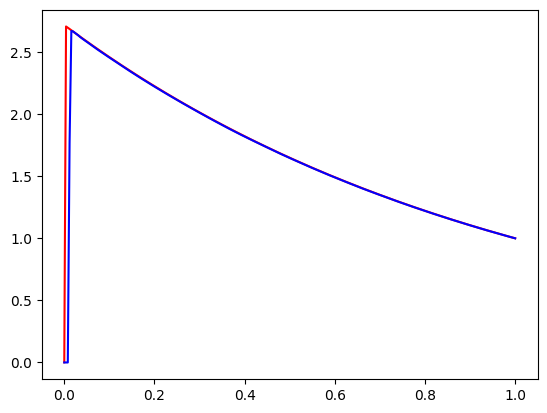

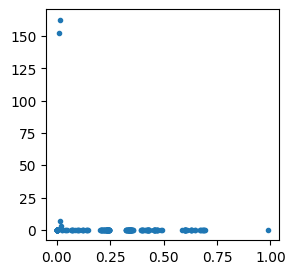

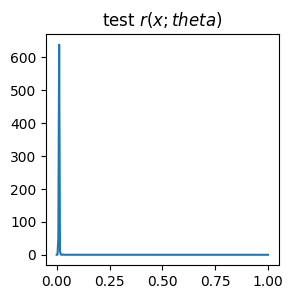

Test residual MSE: 1603.03186
1000 tensor(0.0339, grad_fn=<AddBackward0>)
2000 tensor(0.0179, grad_fn=<AddBackward0>)
3000 tensor(0.0103, grad_fn=<AddBackward0>)
4000 tensor(0.0071, grad_fn=<AddBackward0>)
5000 tensor(0.0041, grad_fn=<AddBackward0>)
6000 tensor(0.0023, grad_fn=<AddBackward0>)
7000 tensor(0.0017, grad_fn=<AddBackward0>)
8000 tensor(0.0014, grad_fn=<AddBackward0>)
9000 tensor(0.0012, grad_fn=<AddBackward0>)
10000 tensor(0.1834, grad_fn=<AddBackward0>)
11000 tensor(0.0561, grad_fn=<AddBackward0>)
12000 tensor(0.0241, grad_fn=<AddBackward0>)
13000 tensor(0.0078, grad_fn=<AddBackward0>)
14000 tensor(0.0048, grad_fn=<AddBackward0>)
15000 tensor(0.0033, grad_fn=<AddBackward0>)
16000 tensor(0.0025, grad_fn=<AddBackward0>)
17000 tensor(0.0022, grad_fn=<AddBackward0>)
18000 tensor(0.0017, grad_fn=<AddBackward0>)
19000 tensor(0.0014, grad_fn=<AddBackward0>)
20000 tensor(0.0011, grad_fn=<AddBackward0>)
21000 tensor(0.0009, grad_fn=<AddBackward0>)
22000 tensor(0.0013, grad_fn=<AddB

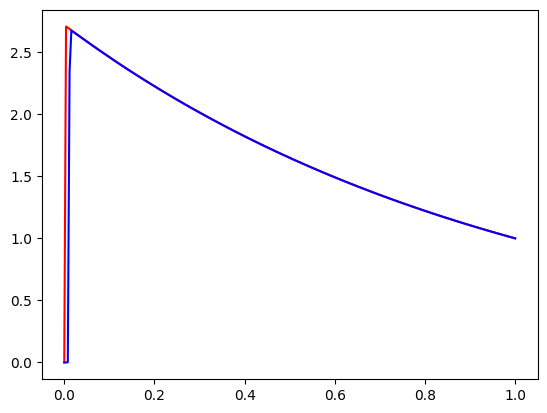

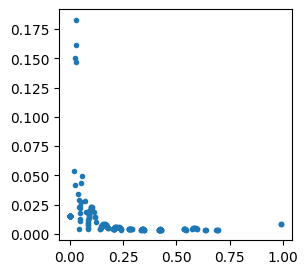

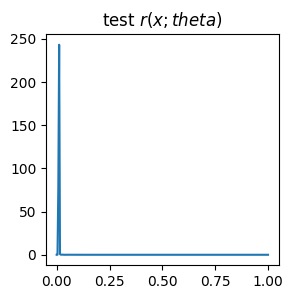

Test residual MSE: 254.43744
1000 tensor(0.0005, grad_fn=<AddBackward0>)
2000 tensor(0.0003, grad_fn=<AddBackward0>)
3000 tensor(0.0003, grad_fn=<AddBackward0>)
4000 tensor(0.0003, grad_fn=<AddBackward0>)
5000 tensor(0.0002, grad_fn=<AddBackward0>)
6000 tensor(0.0004, grad_fn=<AddBackward0>)
7000 tensor(0.0004, grad_fn=<AddBackward0>)
8000 tensor(0.0103, grad_fn=<AddBackward0>)
9000 tensor(0.0007, grad_fn=<AddBackward0>)
10000 tensor(0.0003, grad_fn=<AddBackward0>)
11000 tensor(0.0002, grad_fn=<AddBackward0>)
12000 tensor(0.0002, grad_fn=<AddBackward0>)
13000 tensor(0.0002, grad_fn=<AddBackward0>)
14000 tensor(0.0002, grad_fn=<AddBackward0>)
15000 tensor(0.0002, grad_fn=<AddBackward0>)
16000 tensor(0.0002, grad_fn=<AddBackward0>)
17000 tensor(0.0002, grad_fn=<AddBackward0>)
18000 tensor(0.0001, grad_fn=<AddBackward0>)
19000 tensor(0.0017, grad_fn=<AddBackward0>)
20000 tensor(0.0006, grad_fn=<AddBackward0>)
21000 tensor(0.0009, grad_fn=<AddBackward0>)
22000 tensor(0.0005, grad_fn=<AddBa

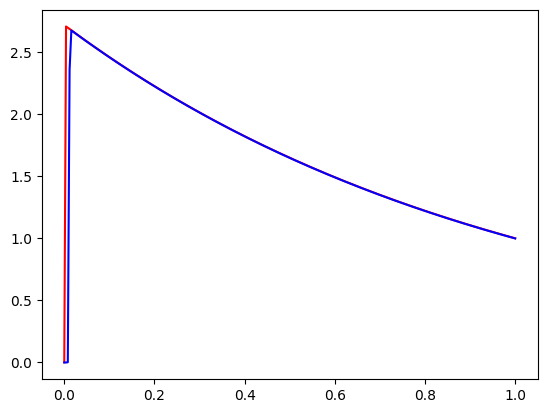

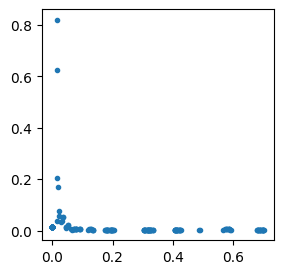

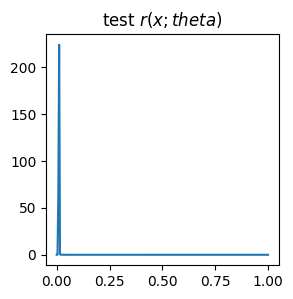

Test residual MSE: 211.80592
1000 tensor(0.0003, grad_fn=<AddBackward0>)
2000 tensor(0.0003, grad_fn=<AddBackward0>)
3000 tensor(0.0028, grad_fn=<AddBackward0>)
4000 tensor(0.0004, grad_fn=<AddBackward0>)
5000 tensor(0.0007, grad_fn=<AddBackward0>)
6000 tensor(0.0019, grad_fn=<AddBackward0>)
7000 tensor(0.0004, grad_fn=<AddBackward0>)
8000 tensor(0.0008, grad_fn=<AddBackward0>)
9000 tensor(0.0004, grad_fn=<AddBackward0>)
10000 tensor(0.0003, grad_fn=<AddBackward0>)
11000 tensor(0.0006, grad_fn=<AddBackward0>)
12000 tensor(0.0001, grad_fn=<AddBackward0>)
13000 tensor(0.0002, grad_fn=<AddBackward0>)
14000 tensor(0.0015, grad_fn=<AddBackward0>)
15000 tensor(0.0013, grad_fn=<AddBackward0>)
16000 tensor(0.0005, grad_fn=<AddBackward0>)
17000 tensor(0.0003, grad_fn=<AddBackward0>)
18000 tensor(0.0006, grad_fn=<AddBackward0>)
19000 tensor(0.0003, grad_fn=<AddBackward0>)
20000 tensor(0.0009, grad_fn=<AddBackward0>)
21000 tensor(0.0001, grad_fn=<AddBackward0>)
22000 tensor(0.0005, grad_fn=<AddBa

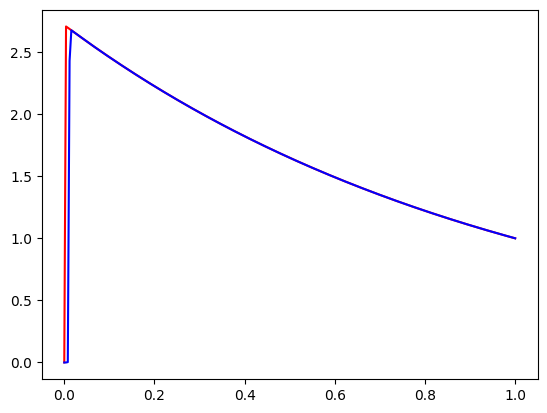

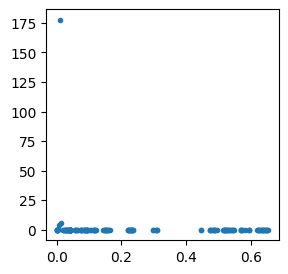

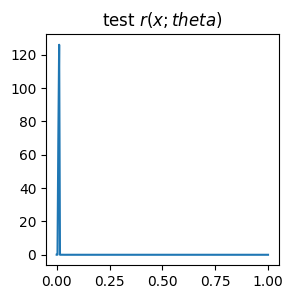

Test residual MSE: 80.76761
1000 tensor(0.0078, grad_fn=<AddBackward0>)
2000 tensor(0.0120, grad_fn=<AddBackward0>)
3000 tensor(0.0163, grad_fn=<AddBackward0>)
4000 tensor(0.0015, grad_fn=<AddBackward0>)
5000 tensor(0.0009, grad_fn=<AddBackward0>)
6000 tensor(0.0013, grad_fn=<AddBackward0>)
7000 tensor(0.0005, grad_fn=<AddBackward0>)
8000 tensor(0.0004, grad_fn=<AddBackward0>)
9000 tensor(0.0012, grad_fn=<AddBackward0>)
10000 tensor(0.0003, grad_fn=<AddBackward0>)
11000 tensor(0.0023, grad_fn=<AddBackward0>)
12000 tensor(0.0047, grad_fn=<AddBackward0>)
13000 tensor(0.0002, grad_fn=<AddBackward0>)
14000 tensor(0.0013, grad_fn=<AddBackward0>)
15000 tensor(0.1999, grad_fn=<AddBackward0>)
16000 tensor(0.0200, grad_fn=<AddBackward0>)
17000 tensor(0.0026, grad_fn=<AddBackward0>)
18000 tensor(0.0014, grad_fn=<AddBackward0>)
19000 tensor(0.0010, grad_fn=<AddBackward0>)
20000 tensor(0.0005, grad_fn=<AddBackward0>)
21000 tensor(0.0003, grad_fn=<AddBackward0>)
22000 tensor(0.0002, grad_fn=<AddBac

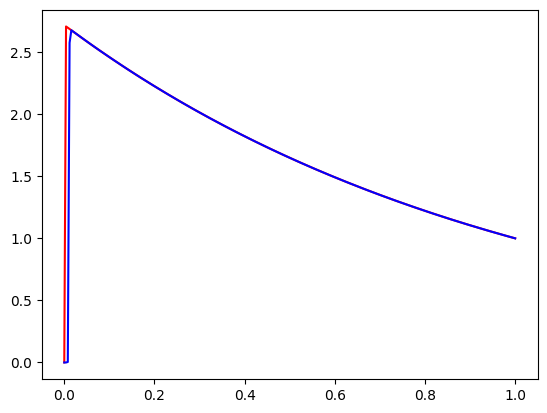

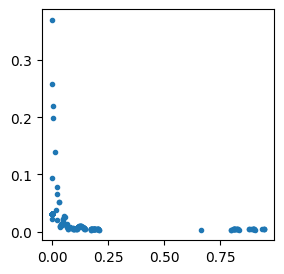

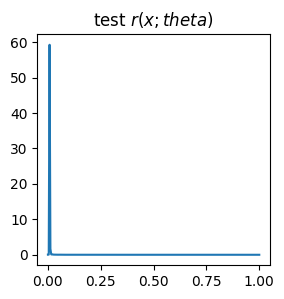

Test residual MSE: 13.72129
1000 tensor(0.0004, grad_fn=<AddBackward0>)
2000 tensor(0.0003, grad_fn=<AddBackward0>)
3000 tensor(0.0007, grad_fn=<AddBackward0>)
4000 tensor(0.2557, grad_fn=<AddBackward0>)
5000 tensor(0.0584, grad_fn=<AddBackward0>)
6000 tensor(0.0087, grad_fn=<AddBackward0>)
7000 tensor(0.0009, grad_fn=<AddBackward0>)
8000 tensor(0.0003, grad_fn=<AddBackward0>)
9000 tensor(0.0002, grad_fn=<AddBackward0>)
10000 tensor(0.0002, grad_fn=<AddBackward0>)
11000 tensor(0.0002, grad_fn=<AddBackward0>)
12000 tensor(0.0002, grad_fn=<AddBackward0>)
13000 tensor(0.0002, grad_fn=<AddBackward0>)
14000 tensor(0.0002, grad_fn=<AddBackward0>)
15000 tensor(0.0006, grad_fn=<AddBackward0>)
16000 tensor(0.0004, grad_fn=<AddBackward0>)
17000 tensor(0.0002, grad_fn=<AddBackward0>)
18000 tensor(0.0002, grad_fn=<AddBackward0>)
19000 tensor(0.0004, grad_fn=<AddBackward0>)
20000 tensor(0.0004, grad_fn=<AddBackward0>)
21000 tensor(0.0002, grad_fn=<AddBackward0>)
22000 tensor(0.1447, grad_fn=<AddBac

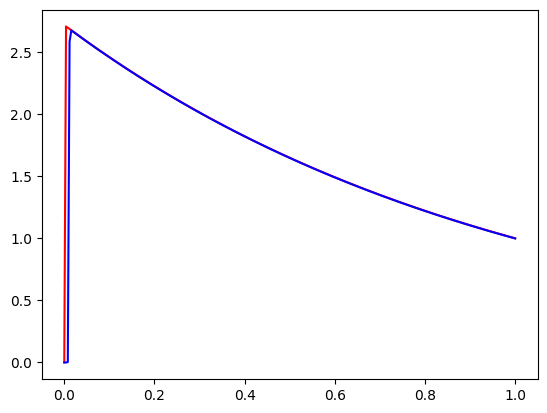

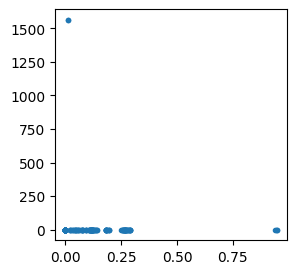

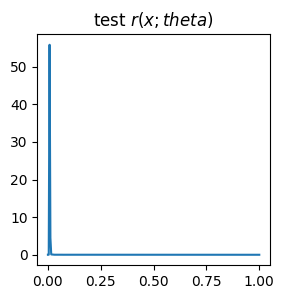

Test residual MSE: 12.25010


In [ ]:
x_adv = np.array([]).reshape((0,1))
''' k=1:30 '''
for i in range(30):
    print("k=", i)
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, epoch=3e4)

In [ ]:
for i in range(5):
    print("k=", i+30)
    x_train = np.vstack([x_train, x_adv])
    x_adv = generate_attack_samples(PINN, device, x_train, N0)
    retrain(PINN, x_train, x_adv, x_boundary, u_boundary, x_test, epoch=3e4)